# Time Series

This tutorial demonstrates time series forecasting using TensorFlow on sunspots dataset.

## Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras import layers, models, optimizers

## Prepare the dataset for training

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2022-04-04 10:26:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-04-04 10:26:34 (61.9 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

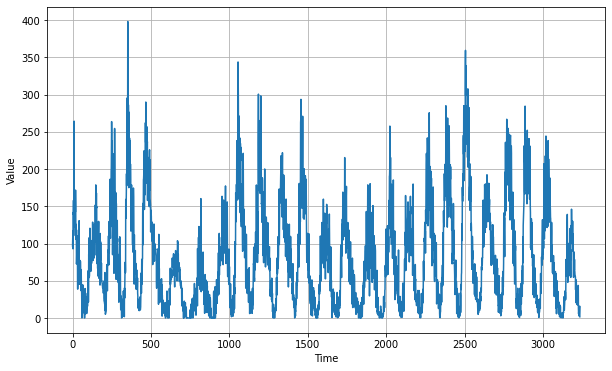

In [ ]:
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)



In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Create the model

In [ ]:
def create_model(window_size):
  model = models.Sequential([
    layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    layers.LSTM(60, return_sequences=True),
    layers.LSTM(60, return_sequences=True),
    layers.Dense(20, input_shape=[window_size], activation="relu"), 
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
  ])
  
  model.compile(loss="mse", 
                optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
  
  return model

In [ ]:
model = create_model(window_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 20)          1220      
                                                                 
 dense_1 (Dense)             (None, None, 10)          210       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 59,881
Trainable params: 59,881
Non-traina

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Train & evaluate the model

In [ ]:
model.fit(train_set, epochs=100)

Epoch 1/100
92/92 [==============================] - 21s 38ms/step - loss: 11466.0654
Epoch 2/100
92/92 [==============================] - 3s 32ms/step - loss: 11361.3018
Epoch 3/100
92/92 [==============================] - 3s 32ms/step - loss: 11267.5752
Epoch 4/100
92/92 [==============================] - 3s 32ms/step - loss: 11166.5322
Epoch 5/100
92/92 [==============================] - 3s 32ms/step - loss: 11048.4932
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 10903.4248
Epoch 7/100
92/92 [==============================] - 3s 32ms/step - loss: 10719.1914
Epoch 8/100
92/92 [==============================] - 3s 32ms/step - loss: 10482.5977
Epoch 9/100
92/92 [==============================] - 3s 32ms/step - loss: 10174.6045
Epoch 10/100
92/92 [==============================] - 3s 31ms/step - loss: 9769.2285
Epoch 11/100
92/92 [==============================] - 3s 32ms/step - loss: 9236.6895
Epoch 12/100
92/92 [==============================] - 3s 32ms/st

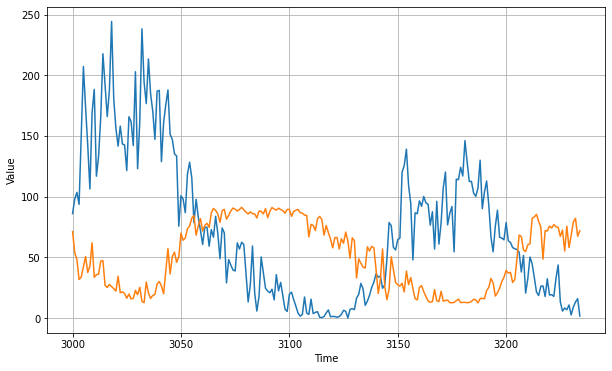

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)